In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.callbacks import ModelCheckpoint

In [66]:
data = pd.read_csv('180801_RFB_510cy_006_DC.csv')
data = data.drop(['시험_시간(s)', '사이클_번호', '사이클_시간(s)', '단계_번호', '단계_시간(s)', '인덱스', '보조전압1(V)', '보조전압2(V)', '보조전압3(V)', '온도(\'C)', '전류_범위', 'OCP(V)', '파워(W)', '부하(Ohm)', '누적_용량(Ah)', '절대값_용량(Ah)'], axis = 1)
data_voltage = data.copy()
data_voltage = data_voltage.pop('전압(V)')

data rows = 262407
Index(['전류(A)', '전압(V)'], dtype='object')
x = (262407, 2)
y = (262407,)


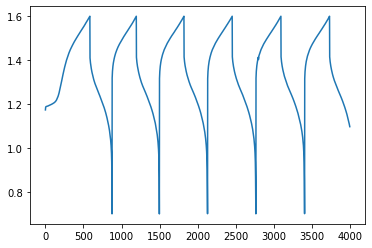

In [67]:
print(f'data rows = {data.shape[0]}')
print(data.columns)
data = data.values
print(f'x = {data.shape}')
print(f'y = {data_voltage.shape}')

# for index in range(data.shape[0]):
#     data[index, 0] = int(data[index, 0][3:5]) * 60 + int(data[index, 0][6:8])
#     data[index, 2] = int(data[index, 2][3:5]) * 60 + int(data[index, 2][6:8])
#     data[index, 4] = int(data[index, 4][3:5]) * 60 + int(data[index, 4][6:8])
pl.plot(data_voltage[:4000])

In [68]:
seq_len = 200
num_batch = int(np.floor(data.shape[0] / seq_len))
print(f'num_batch = {num_batch}')
x_data = []
y_data = []
for batch in range(num_batch):
    x_data.append(data[batch * seq_len:(batch + 1) * seq_len])
    y_data.append(data_voltage[batch * seq_len + 1:(batch + 1) * seq_len + 1])
x_data = np.array(x_data).astype(np.float32)
y_data = np.array(y_data).astype(np.float32)
print(f'x = {x_data.shape}')
print(f'y = {y_data.shape}')
print(x_data[0, 0:6, 1])
print(y_data[0, 0:5])

num_batch = 1312
x = (1312, 200, 2)
y = (1312, 200)
[1.173039  1.1802392 1.18315   1.184682  1.1857544 1.1868268]
[1.1802392 1.18315   1.184682  1.1857544 1.1868268]


In [69]:
split_len = int(round(num_batch * 0.75))
print(split_len)
x_train = x_data[:split_len]
y_train = y_data[:split_len]
x_test = x_data[split_len:]
y_test = y_data[split_len:]
print(y_train.shape)

## 데이터 전처리 끝

984
(984, 200)


In [70]:
loss_dict = {}
num_units = 256
num_epochs = 30
batch_size = 123
epoch_index = 0
model = models.Sequential()
model.add(layers.LSTM(num_units, input_shape=(None, x_train.shape[2]), return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(num_units, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, None, 256)         265216    
                                                                 
 dropout_18 (Dropout)        (None, None, 256)         0         
                                                                 
 lstm_19 (LSTM)              (None, None, 256)         525312    
                                                                 
 dropout_19 (Dropout)        (None, None, 256)         0         
                                                                 
 time_distributed_9 (TimeDis  (None, None, 1)          257       
 tributed)                                                       
                                                                 
Total params: 790,785
Trainable params: 790,785
Non-trainable params: 0
________________________________________________

In [71]:
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 1, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)

Epoch 1/30
7/7 [==============================] - 2s 111ms/step - loss: 0.4488 - val_loss: 0.1097
Epoch 2/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0640 - val_loss: 0.0339
Epoch 3/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0424 - val_loss: 0.0320
Epoch 4/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0338 - val_loss: 0.0315
Epoch 5/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0295 - val_loss: 0.0254
Epoch 6/30
7/7 [==============================] - 0s 52ms/step - loss: 0.0264 - val_loss: 0.0227
Epoch 7/30
7/7 [==============================] - 0s 52ms/step - loss: 0.0244 - val_loss: 0.0205
Epoch 8/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0232 - val_loss: 0.0197
Epoch 9/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0223 - val_loss: 0.0193
Epoch 10/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0215 - val_loss: 0.0183
Epoch 11/30
7/7 [===========

In [72]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)

11/11 [==============================] - 0s 8ms/step
(65600, 1) (65600, 1)


256 units, 30 epochs, sequence length = 200


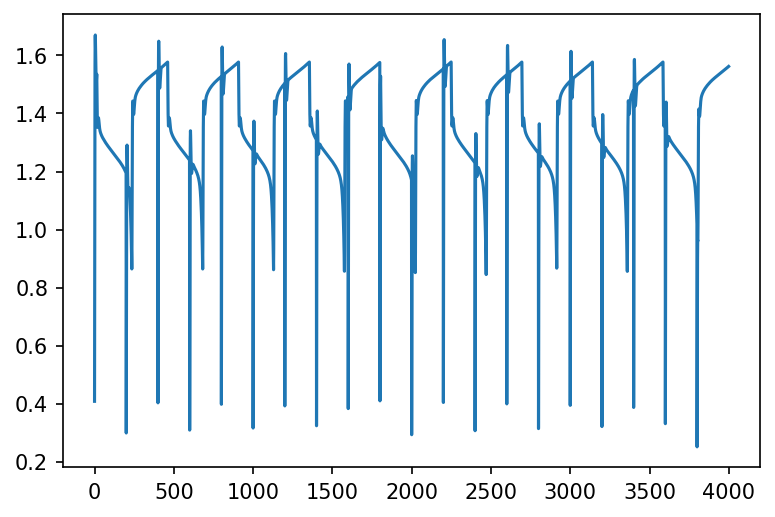

In [73]:
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [74]:
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)

In [75]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)

11/11 [==============================] - 0s 8ms/step
(65600, 1) (65600, 1)


256 units, 60 epochs, sequence length = 200


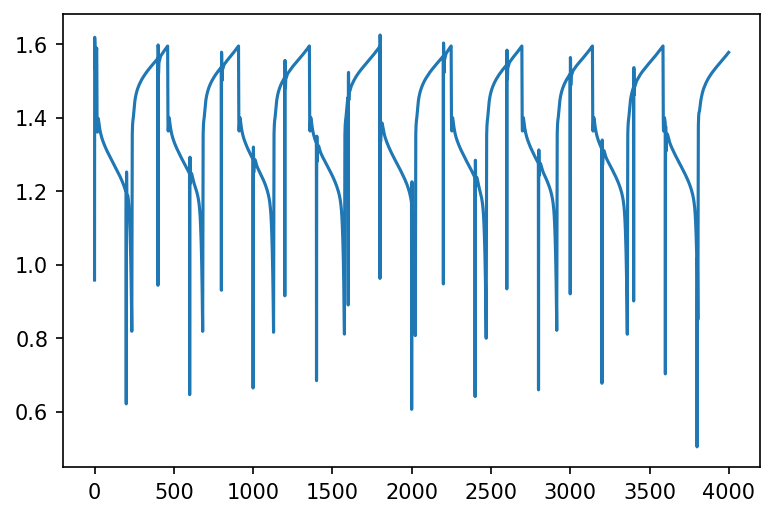

In [76]:
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [77]:
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)

In [78]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)

11/11 [==============================] - 0s 9ms/step
(65600, 1) (65600, 1)


256 units, 90 epochs, sequence length = 200


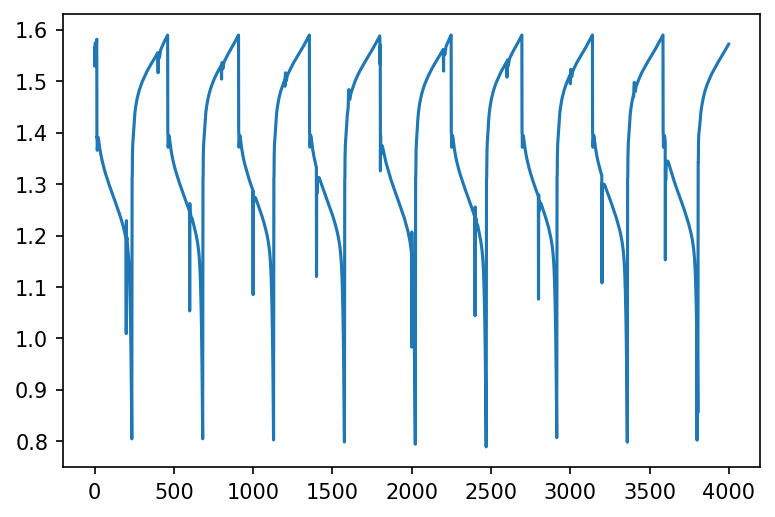

In [79]:
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [80]:
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)

In [81]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)

11/11 [==============================] - 0s 8ms/step
(65600, 1) (65600, 1)


256 units, 120 epochs, sequence length = 200


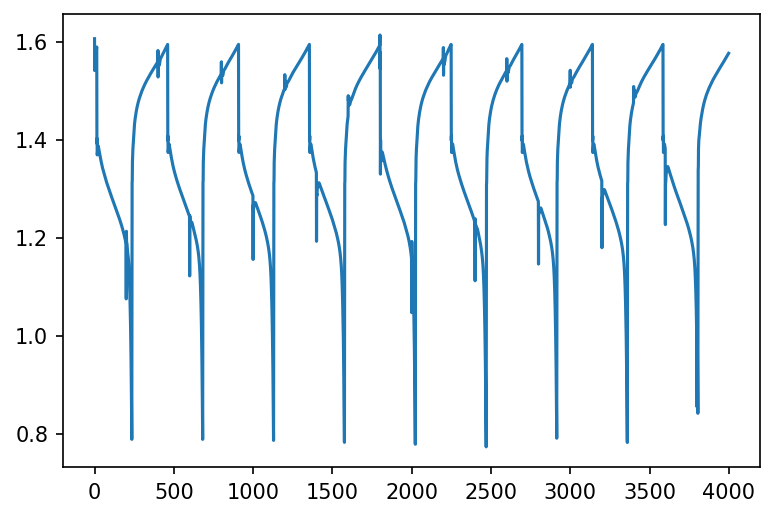

In [82]:
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [83]:
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)

In [84]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')

11/11 [==============================] - 0s 8ms/step
(65600, 1) (65600, 1)
256 units, 150 epochs, sequence length = 200


{'loss_30': 0.009751192294061184, 'loss_60': 0.0031344746239483356, 'loss_90': 0.0011374964378774166, 'loss_120': 0.0010290686041116714, 'loss_150': 0.0009600353077985346}


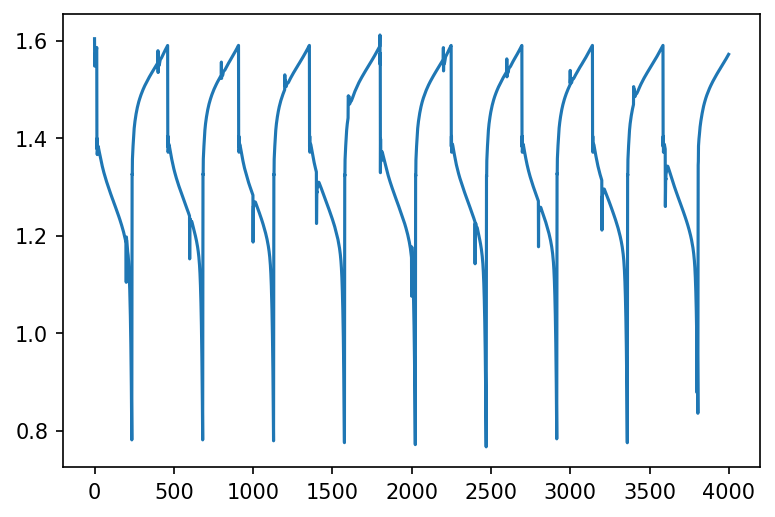

In [85]:
pl.figure(dpi=150)
pl.plot(prediction[:4000])
print(loss_dict)